In [1]:
train_path = "C:/Users/pniki/Documents/GitHub/NLP/Assignment/nlp_assignment/data/traindata.csv"#"/Users/pierre/Documents/MSc_AI/NLP/Assignment/nlp_assignment/data/traindata.csv"
val_path = "C:/Users/pniki/Documents/GitHub/NLP/Assignment/nlp_assignment/data/devdata.csv"#"/Users/pierre/Documents/MSc_AI/NLP/Assignment/nlp_assignment/data/devdata.csv"

In [2]:
import pandas as pd


df_train = pd.read_csv(train_path, sep='\t', header=0, index_col=False)
print(df_train.shape)

df_val = pd.read_csv(val_path, sep='\t', header=0, index_col=False)
print(df_val.shape)


df_train.head()

(1502, 5)
(375, 5)


,positive,AMBIENCE#GENERAL,seating,18:25,"short and sweet – seating is great:it's romantic,cozy and private."
0,positive,AMBIENCE#GENERAL,trattoria,25:34,This quaint and romantic trattoria is at the t...
1,positive,FOOD#QUALITY,food,98:102,The have over 100 different beers to offer thi...
2,negative,SERVICE#GENERAL,STAFF,5:10,THIS STAFF SHOULD BE FIRED.
3,positive,FOOD#STYLE_OPTIONS,menu,4:8,"The menu looked great, and the waiter was very..."
4,positive,FOOD#QUALITY,tuna,4:8,The tuna and wasabe potatoes are excellent.


In [3]:
X_train = df_train.iloc[:, 1:]
y_train = df_train.iloc[:, 0]
print(X_train.shape , y_train.shape)

X_val = df_val.iloc[:, 1:]
y_val = df_val.iloc[:, 0]
print(X_val.shape , y_val.shape)

(1502, 4) (1502,)
(375, 4) (375,)


---

In [4]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Train
aspect_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()
df_train['aspect_category_encoded'] = aspect_encoder.fit_transform(df_train.iloc[:, 1])
y_train_encoded = polarity_encoder.fit_transform(y_train)
X_train_sentences = df_train.iloc[:, -1] # sentence is the last column
print(f"Encoded labels shape: {y_train_encoded.shape}")
print(f"Input sentences shape: {X_train_sentences.shape}")

# Validation
aspect_encoder_val = LabelEncoder()
polarity_encoder_val = LabelEncoder()
df_val['aspect_category_encoded'] = aspect_encoder_val.fit_transform(df_val.iloc[:, 1])
y_val_encoded = polarity_encoder_val.fit_transform(y_val)
X_val_sentences = df_val.iloc[:, -1]
print(f"Encoded labels shape: {y_val_encoded.shape}")
print(f"Input sentences shape: {X_val_sentences.shape}")

Encoded labels shape: (1502,)
Input sentences shape: (1502,)
Encoded labels shape: (375,)
Input sentences shape: (375,)


c:\Users\pniki\anaconda3\envs\nlpenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\pniki\anaconda3\envs\nlpenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\pniki\anaconda3\envs\nlpenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\pniki\anaconda3\envs\nlpenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

In [5]:
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class ReviewDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = str(self.sentences.iloc[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
          sentence,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
        )
        
        return {
          'review_text': sentence,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

batch_size = 32

dataset = ReviewDataset(X_train_sentences, y_train_encoded, tokenizer)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

val_dataset = ReviewDataset(X_val_sentences, y_val_encoded, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


c:\Users\pniki\anaconda3\envs\nlpenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from collections import Counter
import torch

def get_class_proportions(data_loader):
    labels_list = []
    # Iterate over the DataLoader and collect all labels
    for data in data_loader:
        labels = data['labels']  # Ensure 'labels' corresponds to your label key
        labels_list.extend(labels.tolist())  # Convert to list and append

    # Count the frequency of each class
    counter = Counter(labels_list)
    
    # Calculate proportions
    total_instances = sum(counter.values())
    proportions = {class_label: count / total_instances for class_label, count in counter.items()}
    
    return counter, proportions

# Assuming `train_loader` and `val_loader` are your DataLoaders
train_counter, train_proportions = get_class_proportions(loader)
val_counter, val_proportions = get_class_proportions(val_loader)

print("Training set class proportions:")
for class_label, proportion in train_proportions.items():
    print(f"Class {class_label}: {proportion:.2f}")

print("\nValidation set class proportions:")
for class_label, proportion in val_proportions.items():
    print(f"Class {class_label}: {proportion:.2f}")


Training set class proportions:
Class 0: 0.26
Class 2: 0.70
Class 1: 0.04

Validation set class proportions:
Class 2: 0.70
Class 0: 0.26
Class 1: 0.04


In [7]:
from transformers import BertModel
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop1 = nn.Dropout(p=0.3)  # First dropout layer
        # Adding a fully connected layer to introduce more capacity to the model
        self.fc1 = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size // 2)
        self.drop2 = nn.Dropout(p=0.2)  # Second dropout layer
        # Layer normalization
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size // 2)
        # Final output layer
        self.out = nn.Linear(self.bert.config.hidden_size // 2, n_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        dropped_output = self.drop1(pooled_output)
        # Applying the fully connected layer after the first dropout
        fc1_output = F.relu(self.fc1(dropped_output))
        dropped_output = self.drop2(fc1_output)
        # Applying layer normalization
        norm_output = self.layer_norm(dropped_output)
        return self.out(norm_output)


model = SentimentClassifier(len(polarity_encoder.classes_)).to('cuda')


In [8]:
print(len(polarity_encoder.classes_))

3


In [9]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

optimizer = AdamW(model.parameters(), lr=1e-5)


import torch

# Your previously determined class frequencies
class_proportions = {0: 0.26, 1: 0.04, 2: 0.7}

# Calculate class weights as the square root of the inverse class frequency
class_weights = {class_label: (1.0 / proportion) for class_label, proportion in class_proportions.items()}

# Normalize the weights so that they sum up to the number of classes (to keep the loss magnitude consistent)
weight_sum = sum(class_weights.values())
num_classes = len(class_weights)
class_weights = {class_label: (weight / weight_sum) * num_classes for class_label, weight in class_weights.items()}

# Convert class weights to a tensor
weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float32)

# Apply this tensor to your loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor).to('cuda')



# Training loop
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return correct_predictions.double() / n_examples, np.mean(losses)




In [10]:
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # metrics
    precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)

    return correct_predictions.double() / n_examples, np.mean(losses), precision, recall, f1

def train_model(model, train_data_loader, val_data_loader, loss_fn, optimizer, device, epochs=4):
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, len(train_data_loader.dataset))
        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss, val_precision, val_recall, val_f1 = eval_model(model, val_data_loader, loss_fn, device, len(val_data_loader.dataset))
        print(f'Val loss {val_loss} accuracy {val_acc}')
        print(f'Precision: {val_precision}, Recall: {val_recall}, F1-score: {val_f1}\n')


train_model(model, loader, val_loader, loss_fn, optimizer, 'cuda', epochs=10)


Epoch 1/10
----------
Train loss 1.1657410936152681 accuracy 0.41278295605858856
Val loss 1.081123451391856 accuracy 0.6533333333333333
Precision: 0.5902814381678326, Recall: 0.6533333333333333, F1-score: 0.6135675528378185

Epoch 2/10
----------
Train loss 1.131035698221085 accuracy 0.4527296937416778
Val loss 1.0927703231573105 accuracy 0.624
Precision: 0.5999235865192358, Recall: 0.624, F1-score: 0.6117226979091609

Epoch 3/10
----------
Train loss 1.1352579111748553 accuracy 0.46071904127829566
Val loss 1.1186865270137787 accuracy 0.648
Precision: 0.5906638237384506, Recall: 0.648, F1-score: 0.6132885563162271

Epoch 4/10
----------
Train loss 1.1118084065457607 accuracy 0.4294274300932091
Val loss 1.0790430804093678 accuracy 0.64
Precision: 0.601394168611357, Recall: 0.64, F1-score: 0.6191400966183574

Epoch 5/10
----------
Train loss 1.10327665856544 accuracy 0.4487350199733689
Val loss 1.091362789273262 accuracy 0.64
Precision: 0.601394168611357, Recall: 0.64, F1-score: 0.619140

In [11]:
import numpy as np
import torch

def eval_model_with_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)


            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels


predictions, true_labels = eval_model_with_predictions(model, val_loader, 'cuda')

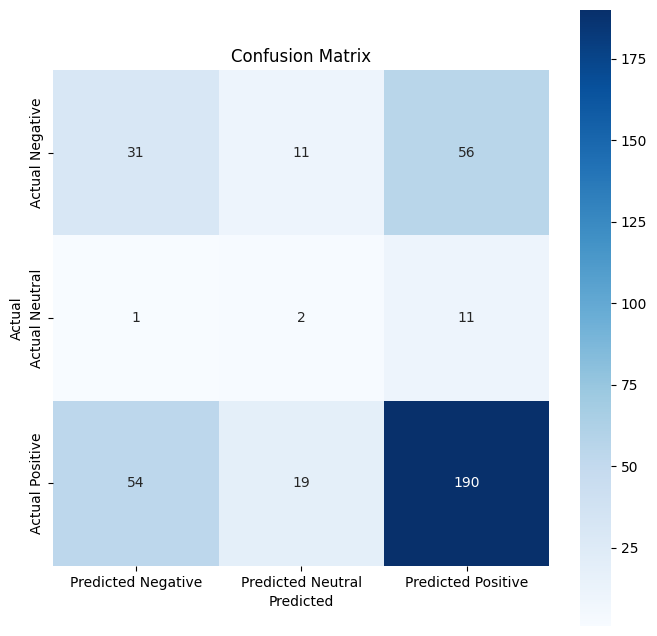

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



cm = confusion_matrix(true_labels, predictions)


fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues", square=True,
            xticklabels=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Neutral', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
